In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri May 20 15:43:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
import matplotlib.pyplot as plt 
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Unzip folder and define data directory.
data_source = "/content/drive/MyDrive/Covid_Dataset.rar" 
data_output = "/content"
!unrar x -Y "/content/drive/MyDrive/Covid_Dataset.rar" "/content"

Streaming output truncated to the last 5000 lines.
Extracting  /content/Covid_Dataset/train/Normal/Normal_1077.png           50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10770.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10771.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10772.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10773.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10774.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10775.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10776.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10778.png          50%  OK 
Extracting  /content/Covid_Dataset/train/Normal/Normal_10781.png          50%  OK 
Extracting  /content/Covid_Da

In [5]:
#Define the hyper parameters
data_dir = "/content/Covid_Dataset"
classes = ['COVID','Normal']
initial_epochs = 50
initial_LR = 0.0001
dropout = 0.2
batch_size = 32
configuration = 'DenseNet_'+str(initial_LR)+'_WD_'+str(dropout)+'_'+str(batch_size)

In [6]:
! mkdir $configuration

In [7]:
train_path = data_dir + '//train'
valid_path = data_dir + '//valid'
test_path = data_dir + '//test'

In [8]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input) \
    .flow_from_directory(directory=train_path, classes=classes, batch_size=batch_size)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input) \
    .flow_from_directory(directory=valid_path, classes=classes, batch_size=batch_size)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input) \
    .flow_from_directory(directory=test_path, classes=classes, batch_size=batch_size, shuffle=False)

Found 8500 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 1252 images belonging to 2 classes.


In [9]:
#Define input shape and use the weights from Imagenet and the network
INPUT_SHAPE = (224,224,3) 
base_model = DenseNet121(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')

29097984/29084464 [==============================] - 1s 0us/step


In [10]:
for layer in base_model.layers:
  if('conv1' in layer.name or 'conv2' in layer.name):
    layer.trainable = False
  else:
    continue

In [11]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(2, activation = 'sigmoid'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 2050      
                                                                 
Total params: 7,039,554
Trainable params: 6,611,330
Non-trainable params: 428,224
_________________________________________________________________


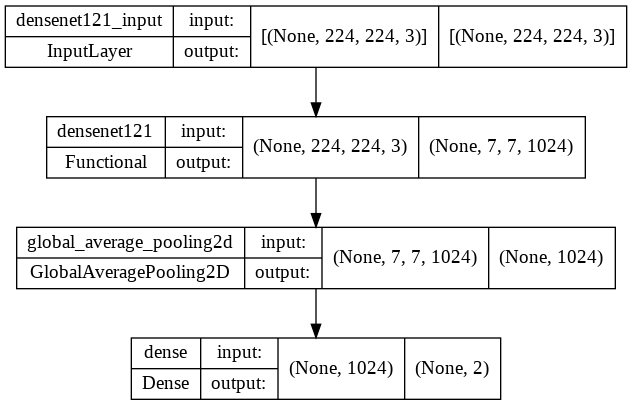

In [13]:
tf.keras.utils.plot_model(model, to_file= '/content/'+configuration+'/'+configuration+'_MODEL.png', show_shapes=True, show_layer_names=True)

In [14]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('/content/'+configuration+'/'+configuration+'.h5', monitor='val_loss', save_best_only=True, mode='min')
model.compile(optimizer=Adam(learning_rate=initial_LR, decay=initial_LR / initial_epochs), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
history = model.fit(
      train_batches,
      epochs = initial_epochs,
      validation_data=valid_batches,
      verbose=1,
      callbacks = [earlystopping_callback,checkpoint_callback]
    )

Epoch 1/50
266/266 [==============================] - 118s 343ms/step - loss: 0.1057 - accuracy: 0.9593 - val_loss: 0.0649 - val_accuracy: 0.9750
Epoch 2/50
266/266 [==============================] - 90s 338ms/step - loss: 0.0222 - accuracy: 0.9928 - val_loss: 0.0225 - val_accuracy: 0.9900
Epoch 3/50
266/266 [==============================] - 89s 334ms/step - loss: 0.0155 - accuracy: 0.9941 - val_loss: 0.1323 - val_accuracy: 0.9650
Epoch 4/50
266/266 [==============================] - 89s 333ms/step - loss: 0.0114 - accuracy: 0.9961 - val_loss: 0.0368 - val_accuracy: 0.9825
Epoch 5/50
266/266 [==============================] - 90s 337ms/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 0.0114 - val_accuracy: 0.9925
Epoch 6/50
266/266 [==============================] - 89s 333ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0130 - val_accuracy: 0.9925
Epoch 7/50
266/266 [==============================] - 89s 333ms/step - loss: 0.0137 - accuracy: 0.9954 - val_loss: 0.1026 - val_a

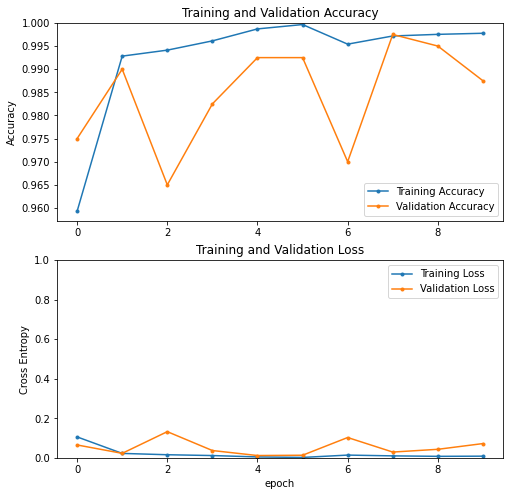

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', marker = '.')
plt.plot(val_acc, label='Validation Accuracy', marker = '.')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', marker = '.')
plt.plot(val_loss, label='Validation Loss', marker = '.')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('/content/'+configuration+'/'+configuration+'_CURVE.png')
plt.show()

In [17]:
ran_epochs = len(history.history['accuracy'])
best_epoch = 0
if(ran_epochs != 50):
  if(ran_epochs > 5):
    best_epoch = ran_epochs - 6  
  else:
    best_epoch = 0
else:
  best_epoch = 49

In [18]:
train_accuracy = history.history['accuracy'][best_epoch]
train_loss = history.history['loss'][best_epoch]
train_accuracy = round(train_accuracy * 100,2)
train_loss = round(train_loss,2)
print(f'Training Accuracy: {train_accuracy}%')
print(f'Training Loss: {train_loss}')

Training Accuracy: 99.87%
Training Loss: 0.0


In [19]:
valid_accuracy = history.history['val_accuracy'][best_epoch]
valid_loss = history.history['val_loss'][best_epoch]
valid_accuracy = round(valid_accuracy * 100,2)
valid_loss = round(valid_loss,2)
print(f'Validation Accuracy: {valid_accuracy}%')
print(f'Validation Loss: {valid_loss}')

Validation Accuracy: 99.25%
Validation Loss: 0.01


In [20]:
#Returns the loss value & metrics values for the model in test mode.
test_loss, test_accuracy = model.evaluate(test_batches)
test_accuracy = round(test_accuracy * 100,2)
test_loss = round(test_loss,2)
print(f'Testing Accuracy: {test_accuracy}%')
print(f'Testing Loss: {test_loss}')

40/40 [==============================] - 6s 144ms/step - loss: 0.0275 - accuracy: 0.9904
Testing Accuracy: 99.04%
Testing Loss: 0.03


In [21]:
results = {'Training Accuracy': train_accuracy, 'Training Loss':train_loss,
           'Validation Accuracy':valid_accuracy,'Validation Loss':valid_loss,
           'Testing Accuracy':test_accuracy,'Testing Loss':test_loss}
results_df = pd.DataFrame(results, index = [configuration])
results_df = results_df.round(2)
results_df.to_csv('/content/'+configuration+'/'+configuration+'_RESULTS.csv')
results_df

,Training Accuracy,Training Loss,Validation Accuracy,Validation Loss,Testing Accuracy,Testing Loss
DenseNet_0.0001_WD_0.2_32,99.87,0.0,99.25,0.01,99.04,0.03


In [22]:
predictions = model.predict(x=test_batches)

In [23]:
#let's print a classification report
from sklearn.metrics import classification_report, confusion_matrix
cr = classification_report(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1), target_names=classes, output_dict=True)
df = pd.DataFrame(cr).transpose()
df = df.round(2)
df.to_csv('/content/'+configuration+'/'+configuration+'_CR.csv')
print(df)

              precision  recall  f1-score  support
COVID              0.99    0.99      0.99   626.00
Normal             0.99    0.99      0.99   626.00
accuracy           0.99    0.99      0.99     0.99
macro avg          0.99    0.99      0.99  1252.00
weighted avg       0.99    0.99      0.99  1252.00


In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('/content/'+configuration+'/'+configuration+'_CM.png')

Confusion matrix, without normalization


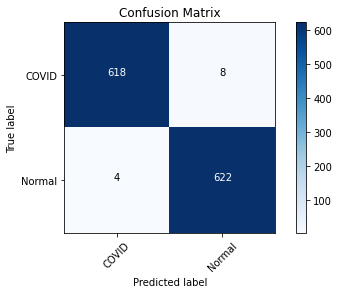

In [25]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix')

In [26]:
! cp -r "/content/"$configuration "/content/drive/MyDrive/Big Data Management/Project/Networks"